In [1]:
import argparse
import datetime
import json
import random
import time
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import DataLoader, DistributedSampler

import datasets
import util.misc as utils
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate, train_one_epoch
from models import build_model

import matplotlib.pyplot as plt
import torchvision

torch.set_printoptions(sci_mode=False, precision=4)

In [2]:
from argparse import Namespace
# panoptic obj detector args:
# args = Namespace(lr=0.0001, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=300, lr_drop=200, clip_max_norm=0.1, frozen_weights=None, backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, aux_loss=True, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, dataset_file='coco_panoptic', coco_path='dataset/coco', coco_panoptic_path='dataset/coco_panoptic', remove_difficult=False, output_dir='./output/path/box_model', device='cuda', seed=42, resume='', start_epoch=0, eval=False, num_workers=2, world_size=1, dist_url='env://', distributed=False)
# panoptic mask model args
args=Namespace(lr=0.0001, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=25, lr_drop=15, clip_max_norm=0.1, frozen_weights='./output/box_model2/checkpoint.pth', backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=True, aux_loss=True, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, dataset_file='coco_panoptic', coco_path='dataset/coco', coco_panoptic_path='dataset/coco_panoptic', remove_difficult=False, output_dir='./output/path/segm_model', device='cuda', seed=42, resume='', start_epoch=0, eval=False, num_workers=2, world_size=1, dist_url='env://')

In [3]:
categories = [{"supercategory": "person", "color": [220, 20, 60], "isthing": 1, "id": 1, "name": "person"}, {"supercategory": "vehicle", "color": [119, 11, 32], "isthing": 1, "id": 2, "name": "bicycle"}, {"supercategory": "vehicle", "color": [0, 0, 142], "isthing": 1, "id": 3, "name": "car"}, {"supercategory": "vehicle", "color": [0, 0, 230], "isthing": 1, "id": 4, "name": "motorcycle"}, {"supercategory": "vehicle", "color": [106, 0, 228], "isthing": 1, "id": 5, "name": "airplane"}, {"supercategory": "vehicle", "color": [0, 60, 100], "isthing": 1, "id": 6, "name": "bus"}, {"supercategory": "vehicle", "color": [0, 80, 100], "isthing": 1, "id": 7, "name": "train"}, {"supercategory": "vehicle", "color": [0, 0, 70], "isthing": 1, "id": 8, "name": "truck"}, {"supercategory": "vehicle", "color": [0, 0, 192], "isthing": 1, "id": 9, "name": "boat"}, {"supercategory": "outdoor", "color": [250, 170, 30], "isthing": 1, "id": 10, "name": "traffic light"}, {"supercategory": "outdoor", "color": [100, 170, 30], "isthing": 1, "id": 11, "name": "fire hydrant"}, {"supercategory": "outdoor", "color": [220, 220, 0], "isthing": 1, "id": 13, "name": "stop sign"}, {"supercategory": "outdoor", "color": [175, 116, 175], "isthing": 1, "id": 14, "name": "parking meter"}, {"supercategory": "outdoor", "color": [250, 0, 30], "isthing": 1, "id": 15, "name": "bench"}, {"supercategory": "animal", "color": [165, 42, 42], "isthing": 1, "id": 16, "name": "bird"}, {"supercategory": "animal", "color": [255, 77, 255], "isthing": 1, "id": 17, "name": "cat"}, {"supercategory": "animal", "color": [0, 226, 252], "isthing": 1, "id": 18, "name": "dog"}, {"supercategory": "animal", "color": [182, 182, 255], "isthing": 1, "id": 19, "name": "horse"}, {"supercategory": "animal", "color": [0, 82, 0], "isthing": 1, "id": 20, "name": "sheep"}, {"supercategory": "animal", "color": [120, 166, 157], "isthing": 1, "id": 21, "name": "cow"}, {"supercategory": "animal", "color": [110, 76, 0], "isthing": 1, "id": 22, "name": "elephant"}, {"supercategory": "animal", "color": [174, 57, 255], "isthing": 1, "id": 23, "name": "bear"}, {"supercategory": "animal", "color": [199, 100, 0], "isthing": 1, "id": 24, "name": "zebra"}, {"supercategory": "animal", "color": [72, 0, 118], "isthing": 1, "id": 25, "name": "giraffe"}, {"supercategory": "accessory", "color": [255, 179, 240], "isthing": 1, "id": 27, "name": "backpack"}, {"supercategory": "accessory", "color": [0, 125, 92], "isthing": 1, "id": 28, "name": "umbrella"}, {"supercategory": "accessory", "color": [209, 0, 151], "isthing": 1, "id": 31, "name": "handbag"}, {"supercategory": "accessory", "color": [188, 208, 182], "isthing": 1, "id": 32, "name": "tie"}, {"supercategory": "accessory", "color": [0, 220, 176], "isthing": 1, "id": 33, "name": "suitcase"}, {"supercategory": "sports", "color": [255, 99, 164], "isthing": 1, "id": 34, "name": "frisbee"}, {"supercategory": "sports", "color": [92, 0, 73], "isthing": 1, "id": 35, "name": "skis"}, {"supercategory": "sports", "color": [133, 129, 255], "isthing": 1, "id": 36, "name": "snowboard"}, {"supercategory": "sports", "color": [78, 180, 255], "isthing": 1, "id": 37, "name": "sports ball"}, {"supercategory": "sports", "color": [0, 228, 0], "isthing": 1, "id": 38, "name": "kite"}, {"supercategory": "sports", "color": [174, 255, 243], "isthing": 1, "id": 39, "name": "baseball bat"}, {"supercategory": "sports", "color": [45, 89, 255], "isthing": 1, "id": 40, "name": "baseball glove"}, {"supercategory": "sports", "color": [134, 134, 103], "isthing": 1, "id": 41, "name": "skateboard"}, {"supercategory": "sports", "color": [145, 148, 174], "isthing": 1, "id": 42, "name": "surfboard"}, {"supercategory": "sports", "color": [255, 208, 186], "isthing": 1, "id": 43, "name": "tennis racket"}, {"supercategory": "kitchen", "color": [197, 226, 255], "isthing": 1, "id": 44, "name": "bottle"}, {"supercategory": "kitchen", "color": [171, 134, 1], "isthing": 1, "id": 46, "name": "wine glass"}, {"supercategory": "kitchen", "color": [109, 63, 54], "isthing": 1, "id": 47, "name": "cup"}, {"supercategory": "kitchen", "color": [207, 138, 255], "isthing": 1, "id": 48, "name": "fork"}, {"supercategory": "kitchen", "color": [151, 0, 95], "isthing": 1, "id": 49, "name": "knife"}, {"supercategory": "kitchen", "color": [9, 80, 61], "isthing": 1, "id": 50, "name": "spoon"}, {"supercategory": "kitchen", "color": [84, 105, 51], "isthing": 1, "id": 51, "name": "bowl"}, {"supercategory": "food", "color": [74, 65, 105], "isthing": 1, "id": 52, "name": "banana"}, {"supercategory": "food", "color": [166, 196, 102], "isthing": 1, "id": 53, "name": "apple"}, {"supercategory": "food", "color": [208, 195, 210], "isthing": 1, "id": 54, "name": "sandwich"}, {"supercategory": "food", "color": [255, 109, 65], "isthing": 1, "id": 55, "name": "orange"}, {"supercategory": "food", "color": [0, 143, 149], "isthing": 1, "id": 56, "name": "broccoli"}, {"supercategory": "food", "color": [179, 0, 194], "isthing": 1, "id": 57, "name": "carrot"}, {"supercategory": "food", "color": [209, 99, 106], "isthing": 1, "id": 58, "name": "hot dog"}, {"supercategory": "food", "color": [5, 121, 0], "isthing": 1, "id": 59, "name": "pizza"}, {"supercategory": "food", "color": [227, 255, 205], "isthing": 1, "id": 60, "name": "donut"}, {"supercategory": "food", "color": [147, 186, 208], "isthing": 1, "id": 61, "name": "cake"}, {"supercategory": "furniture", "color": [153, 69, 1], "isthing": 1, "id": 62, "name": "chair"}, {"supercategory": "furniture", "color": [3, 95, 161], "isthing": 1, "id": 63, "name": "couch"}, {"supercategory": "furniture", "color": [163, 255, 0], "isthing": 1, "id": 64, "name": "potted plant"}, {"supercategory": "furniture", "color": [119, 0, 170], "isthing": 1, "id": 65, "name": "bed"}, {"supercategory": "furniture", "color": [0, 182, 199], "isthing": 1, "id": 67, "name": "dining table"}, {"supercategory": "furniture", "color": [0, 165, 120], "isthing": 1, "id": 70, "name": "toilet"}, {"supercategory": "electronic", "color": [183, 130, 88], "isthing": 1, "id": 72, "name": "tv"}, {"supercategory": "electronic", "color": [95, 32, 0], "isthing": 1, "id": 73, "name": "laptop"}, {"supercategory": "electronic", "color": [130, 114, 135], "isthing": 1, "id": 74, "name": "mouse"}, {"supercategory": "electronic", "color": [110, 129, 133], "isthing": 1, "id": 75, "name": "remote"}, {"supercategory": "electronic", "color": [166, 74, 118], "isthing": 1, "id": 76, "name": "keyboard"}, {"supercategory": "electronic", "color": [219, 142, 185], "isthing": 1, "id": 77, "name": "cell phone"}, {"supercategory": "appliance", "color": [79, 210, 114], "isthing": 1, "id": 78, "name": "microwave"}, {"supercategory": "appliance", "color": [178, 90, 62], "isthing": 1, "id": 79, "name": "oven"}, {"supercategory": "appliance", "color": [65, 70, 15], "isthing": 1, "id": 80, "name": "toaster"}, {"supercategory": "appliance", "color": [127, 167, 115], "isthing": 1, "id": 81, "name": "sink"}, {"supercategory": "appliance", "color": [59, 105, 106], "isthing": 1, "id": 82, "name": "refrigerator"}, {"supercategory": "indoor", "color": [142, 108, 45], "isthing": 1, "id": 84, "name": "book"}, {"supercategory": "indoor", "color": [196, 172, 0], "isthing": 1, "id": 85, "name": "clock"}, {"supercategory": "indoor", "color": [95, 54, 80], "isthing": 1, "id": 86, "name": "vase"}, {"supercategory": "indoor", "color": [128, 76, 255], "isthing": 1, "id": 87, "name": "scissors"}, {"supercategory": "indoor", "color": [201, 57, 1], "isthing": 1, "id": 88, "name": "teddy bear"}, {"supercategory": "indoor", "color": [246, 0, 122], "isthing": 1, "id": 89, "name": "hair drier"}, {"supercategory": "indoor", "color": [191, 162, 208], "isthing": 1, "id": 90, "name": "toothbrush"}, {"supercategory": "textile", "color": [255, 255, 128], "isthing": 0, "id": 92, "name": "banner"}, {"supercategory": "textile", "color": [147, 211, 203], "isthing": 0, "id": 93, "name": "blanket"}, {"supercategory": "building", "color": [150, 100, 100], "isthing": 0, "id": 95, "name": "bridge"}, {"supercategory": "raw-material", "color": [168, 171, 172], "isthing": 0, "id": 100, "name": "cardboard"}, {"supercategory": "furniture-stuff", "color": [146, 112, 198], "isthing": 0, "id": 107, "name": "counter"}, {"supercategory": "textile", "color": [210, 170, 100], "isthing": 0, "id": 109, "name": "curtain"}, {"supercategory": "furniture-stuff", "color": [92, 136, 89], "isthing": 0, "id": 112, "name": "door-stuff"}, {"supercategory": "floor", "color": [218, 88, 184], "isthing": 0, "id": 118, "name": "floor-wood"}, {"supercategory": "plant", "color": [241, 129, 0], "isthing": 0, "id": 119, "name": "flower"}, {"supercategory": "food-stuff", "color": [217, 17, 255], "isthing": 0, "id": 122, "name": "fruit"}, {"supercategory": "ground", "color": [124, 74, 181], "isthing": 0, "id": 125, "name": "gravel"}, {"supercategory": "building", "color": [70, 70, 70], "isthing": 0, "id": 128, "name": "house"}, {"supercategory": "furniture-stuff", "color": [255, 228, 255], "isthing": 0, "id": 130, "name": "light"}, {"supercategory": "furniture-stuff", "color": [154, 208, 0], "isthing": 0, "id": 133, "name": "mirror-stuff"}, {"supercategory": "structural", "color": [193, 0, 92], "isthing": 0, "id": 138, "name": "net"}, {"supercategory": "textile", "color": [76, 91, 113], "isthing": 0, "id": 141, "name": "pillow"}, {"supercategory": "ground", "color": [255, 180, 195], "isthing": 0, "id": 144, "name": "platform"}, {"supercategory": "ground", "color": [106, 154, 176], "isthing": 0, "id": 145, "name": "playingfield"}, {"supercategory": "ground", "color": [230, 150, 140], "isthing": 0, "id": 147, "name": "railroad"}, {"supercategory": "water", "color": [60, 143, 255], "isthing": 0, "id": 148, "name": "river"}, {"supercategory": "ground", "color": [128, 64, 128], "isthing": 0, "id": 149, "name": "road"}, {"supercategory": "building", "color": [92, 82, 55], "isthing": 0, "id": 151, "name": "roof"}, {"supercategory": "ground", "color": [254, 212, 124], "isthing": 0, "id": 154, "name": "sand"}, {"supercategory": "water", "color": [73, 77, 174], "isthing": 0, "id": 155, "name": "sea"}, {"supercategory": "furniture-stuff", "color": [255, 160, 98], "isthing": 0, "id": 156, "name": "shelf"}, {"supercategory": "ground", "color": [255, 255, 255], "isthing": 0, "id": 159, "name": "snow"}, {"supercategory": "furniture-stuff", "color": [104, 84, 109], "isthing": 0, "id": 161, "name": "stairs"}, {"supercategory": "building", "color": [169, 164, 131], "isthing": 0, "id": 166, "name": "tent"}, {"supercategory": "textile", "color": [225, 199, 255], "isthing": 0, "id": 168, "name": "towel"}, {"supercategory": "wall", "color": [137, 54, 74], "isthing": 0, "id": 171, "name": "wall-brick"}, {"supercategory": "wall", "color": [135, 158, 223], "isthing": 0, "id": 175, "name": "wall-stone"}, {"supercategory": "wall", "color": [7, 246, 231], "isthing": 0, "id": 176, "name": "wall-tile"}, {"supercategory": "wall", "color": [107, 255, 200], "isthing": 0, "id": 177, "name": "wall-wood"}, {"supercategory": "water", "color": [58, 41, 149], "isthing": 0, "id": 178, "name": "water-other"}, {"supercategory": "window", "color": [183, 121, 142], "isthing": 0, "id": 180, "name": "window-blind"}, {"supercategory": "window", "color": [255, 73, 97], "isthing": 0, "id": 181, "name": "window-other"}, {"supercategory": "plant", "color": [107, 142, 35], "isthing": 0, "id": 184, "name": "tree-merged"}, {"supercategory": "structural", "color": [190, 153, 153], "isthing": 0, "id": 185, "name": "fence-merged"}, {"supercategory": "ceiling", "color": [146, 139, 141], "isthing": 0, "id": 186, "name": "ceiling-merged"}, {"supercategory": "sky", "color": [70, 130, 180], "isthing": 0, "id": 187, "name": "sky-other-merged"}, {"supercategory": "furniture-stuff", "color": [134, 199, 156], "isthing": 0, "id": 188, "name": "cabinet-merged"}, {"supercategory": "furniture-stuff", "color": [209, 226, 140], "isthing": 0, "id": 189, "name": "table-merged"}, {"supercategory": "floor", "color": [96, 36, 108], "isthing": 0, "id": 190, "name": "floor-other-merged"}, {"supercategory": "ground", "color": [96, 96, 96], "isthing": 0, "id": 191, "name": "pavement-merged"}, {"supercategory": "solid", "color": [64, 170, 64], "isthing": 0, "id": 192, "name": "mountain-merged"}, {"supercategory": "plant", "color": [152, 251, 152], "isthing": 0, "id": 193, "name": "grass-merged"}, {"supercategory": "ground", "color": [208, 229, 228], "isthing": 0, "id": 194, "name": "dirt-merged"}, {"supercategory": "raw-material", "color": [206, 186, 171], "isthing": 0, "id": 195, "name": "paper-merged"}, {"supercategory": "food-stuff", "color": [152, 161, 64], "isthing": 0, "id": 196, "name": "food-other-merged"}, {"supercategory": "building", "color": [116, 112, 0], "isthing": 0, "id": 197, "name": "building-other-merged"}, {"supercategory": "solid", "color": [0, 114, 143], "isthing": 0, "id": 198, "name": "rock-merged"}, {"supercategory": "wall", "color": [102, 102, 156], "isthing": 0, "id": 199, "name": "wall-other-merged"}, {"supercategory": "textile", "color": [250, 141, 255], "isthing": 0, "id": 200, "name": "rug-merged"}]
coco_idx_to_label = {}
for elem in categories:
    coco_idx_to_label[elem['id']] = elem['name']
coco_idx_to_label

{1: 'person',
 2: 'bicycle',
 3: 'car',
 4: 'motorcycle',
 5: 'airplane',
 6: 'bus',
 7: 'train',
 8: 'truck',
 9: 'boat',
 10: 'traffic light',
 11: 'fire hydrant',
 13: 'stop sign',
 14: 'parking meter',
 15: 'bench',
 16: 'bird',
 17: 'cat',
 18: 'dog',
 19: 'horse',
 20: 'sheep',
 21: 'cow',
 22: 'elephant',
 23: 'bear',
 24: 'zebra',
 25: 'giraffe',
 27: 'backpack',
 28: 'umbrella',
 31: 'handbag',
 32: 'tie',
 33: 'suitcase',
 34: 'frisbee',
 35: 'skis',
 36: 'snowboard',
 37: 'sports ball',
 38: 'kite',
 39: 'baseball bat',
 40: 'baseball glove',
 41: 'skateboard',
 42: 'surfboard',
 43: 'tennis racket',
 44: 'bottle',
 46: 'wine glass',
 47: 'cup',
 48: 'fork',
 49: 'knife',
 50: 'spoon',
 51: 'bowl',
 52: 'banana',
 53: 'apple',
 54: 'sandwich',
 55: 'orange',
 56: 'broccoli',
 57: 'carrot',
 58: 'hot dog',
 59: 'pizza',
 60: 'donut',
 61: 'cake',
 62: 'chair',
 63: 'couch',
 64: 'potted plant',
 65: 'bed',
 67: 'dining table',
 70: 'toilet',
 72: 'tv',
 73: 'laptop',
 74: 'mo

In [4]:
len(coco_idx_to_label)

133

In [5]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# fix the seed for reproducibility
seed = args.seed + utils.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


In [6]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        output_tensor = []
        for t, m, s in zip(tensor, self.mean, self.std):
            output_tensor.append(t.mul(s).add(m))
            # t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return torch.stack(output_tensor, dim=0)

unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(img, labels, boxes, mask=None):
    h, w = img.shape[1:]
    if mask != None:
        # width
        if torch.where(mask[0])[0].shape[0] > 0:
            mask_w = torch.where(mask[0])[0][0]
            w = min(w, mask_w)
        if torch.where(mask[:, 0])[0].shape[0]:
            mask_h = torch.where(mask[:, 0])[0][0]
            h = min(h, mask_h)
            
    boxes = rescale_bboxes(boxes, (w, h))
    plt.figure(figsize=(16,10))
    unimage = unnorm(img)
    #image = (unimage*256).to(torch.uint8)
    image = unimage
    pil_img = torchvision.transforms.functional.to_pil_image(image)
    plt.imshow(pil_img)
    
    ax = plt.gca()
    colors = COLORS * 100
    for label, (xmin, ymin, xmax, ymax), c in zip(labels, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{coco_idx_to_label.get(label.item(), "NA")}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [7]:
dataset_train = build_dataset(image_set='train', args=args)

/traindata/maksim/miniconda3/envs/detr/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1728945388353/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


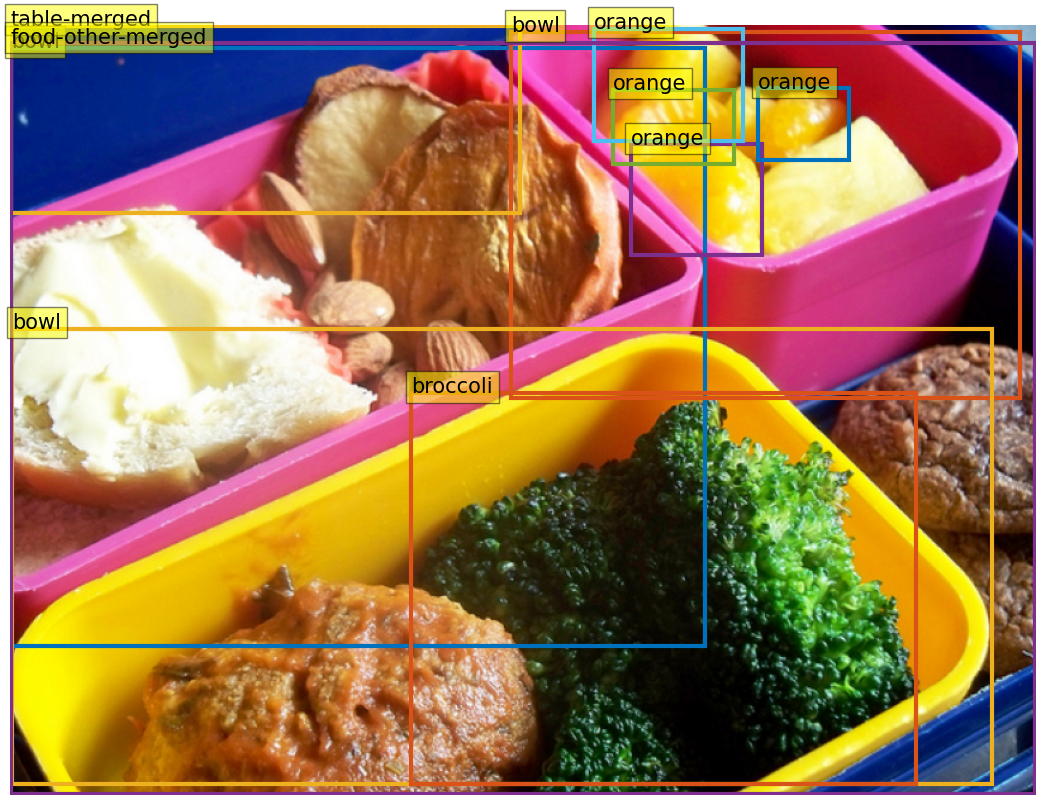

In [8]:
example = dataset_train[0]
plot_results(example[0], example[1]["labels"], example[1]["boxes"])

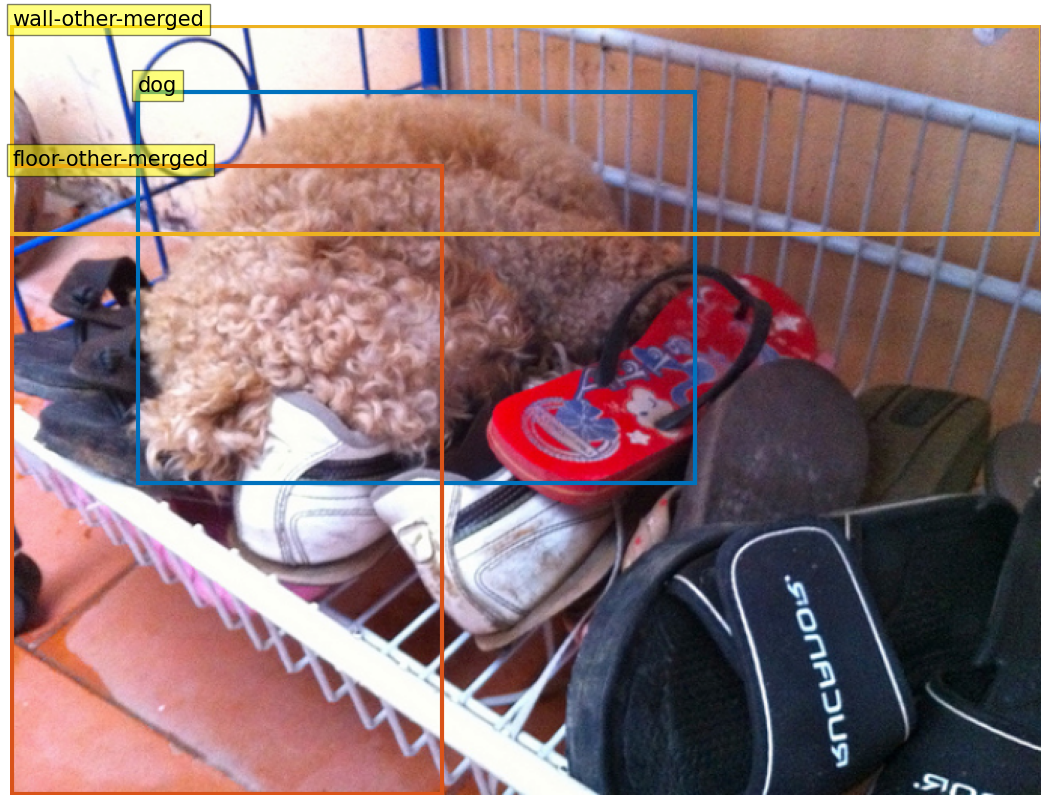

In [9]:
example = dataset_train[5]
plot_results(example[0], example[1]["labels"], example[1]["boxes"])

In [10]:
sampler_train = torch.utils.data.RandomSampler(dataset_train)    
batch_sampler_train = torch.utils.data.BatchSampler(
    sampler_train, args.batch_size, drop_last=True)
data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                                   collate_fn=utils.collate_fn, num_workers=args.num_workers)


In [11]:
for samples, targets in data_loader_train:
    break
samples.tensors.shape

torch.Size([2, 3, 800, 1039])

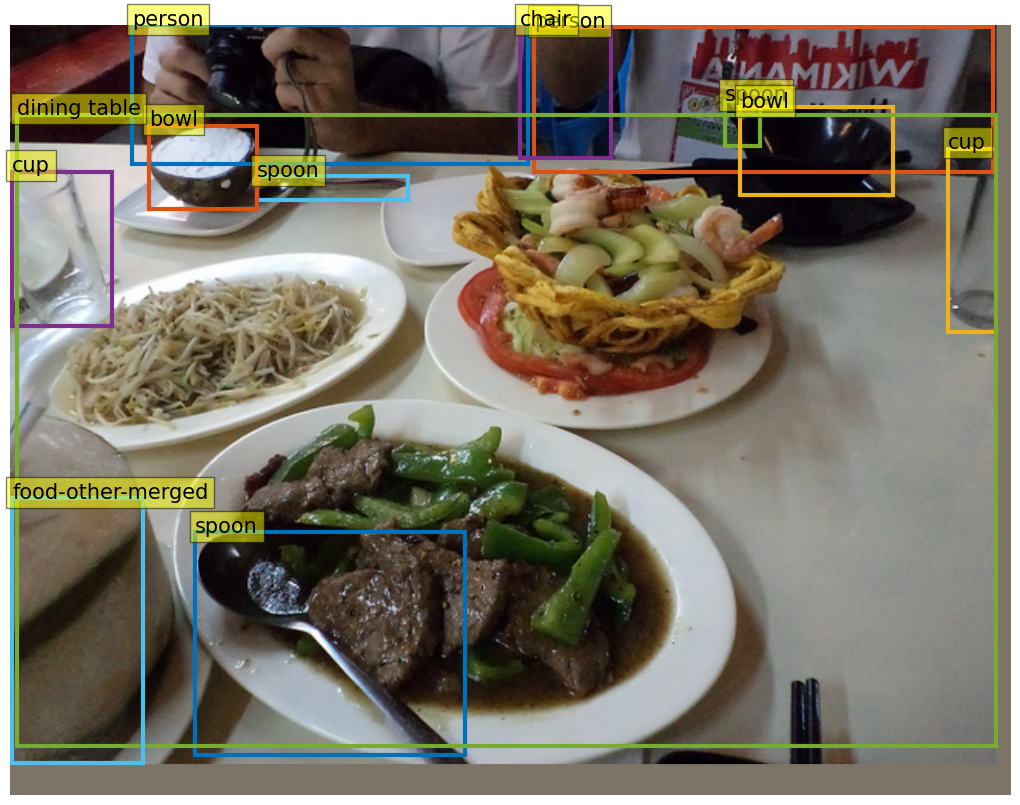

In [12]:
plot_results(samples.tensors[1], targets[1]["labels"], targets[1]["boxes"], mask=samples.mask[1])

In [13]:
model, criterion, postprocessors = build_model(args)
model = model.to(args.device)
model

/traindata/maksim/miniconda3/envs/detr/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/traindata/maksim/miniconda3/envs/detr/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DETRsegm(
  (detr): DETR(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-5): 6 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
            )
            (linear1): Linear(in_features=256, out_features=2048, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=2048, out_features=256, bias=True)
            (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (decoder): TransformerDecoder(
        (layers): ModuleList(
          (0-5): 6 x TransformerDecoderLayer(
            (self_attn): MultiheadAttention(
             

In [14]:
device = args.device
samples = samples.to(device)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [20]:
model

DETRsegm(
  (detr): DETR(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-5): 6 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
            )
            (linear1): Linear(in_features=256, out_features=2048, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=2048, out_features=256, bias=True)
            (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (decoder): TransformerDecoder(
        (layers): ModuleList(
          (0-5): 6 x TransformerDecoderLayer(
            (self_attn): MultiheadAttention(
             

In [22]:
preds = model(samples)
preds

{'pred_logits': tensor([[[-0.1220,  0.2268,  0.3407,  ...,  0.3073, -0.2380, -0.1752],
          [ 0.2591,  0.2534,  0.7888,  ...,  0.8303, -0.1715, -0.1910],
          [ 0.0258,  0.1482,  0.2017,  ...,  0.1621, -0.1169,  0.0210],
          ...,
          [ 0.0541,  0.2741,  0.3181,  ...,  0.6015, -0.4404,  0.0157],
          [ 0.0084,  0.5097,  0.2956,  ...,  0.3767, -0.0464, -0.6623],
          [ 0.3657,  0.3736,  0.3598,  ...,  0.3031, -0.7620, -0.0301]],
 
         [[ 0.2186,  0.4170,  0.1135,  ...,  0.5053, -0.9515, -0.1051],
          [ 0.3696, -0.1356,  0.2485,  ...,  0.5451, -0.4861,  0.1023],
          [ 0.1028, -0.1371, -0.1172,  ...,  0.5223, -0.1439, -0.0959],
          ...,
          [ 0.2855, -0.1275, -0.0562,  ...,  0.4319, -0.2133, -0.0381],
          [ 0.3474,  0.1405,  0.1591,  ...,  0.4328, -0.6121, -0.5659],
          [ 0.2431,  0.4972,  0.1769,  ...,  0.4973, -0.4942,  0.0801]]],
        device='cuda:0'),
 'pred_boxes': tensor([[[0.5020, 0.5006, 0.5180, 0.5133],
  

In [16]:
list(preds.keys())

['pred_logits', 'pred_boxes', 'aux_outputs', 'pred_masks']

In [17]:
samples.tensors.shape

torch.Size([2, 3, 800, 1039])

In [18]:
preds["pred_logits"].shape, preds["pred_boxes"].shape, preds["pred_masks"].shape

(torch.Size([2, 100, 251]),
 torch.Size([2, 100, 4]),
 torch.Size([2, 100, 200, 260]))

In [19]:
preds["pred_masks"]

tensor([[[[ 0.1249, -0.0349,  0.2299,  ..., -0.1677,  0.0123, -0.0179],
          [ 0.2039,  0.5162,  0.6276,  ...,  0.1989,  0.4166,  0.4876],
          [ 0.1775,  0.4852,  0.3892,  ...,  0.4885,  0.3509,  0.3593],
          ...,
          [ 0.9690, -0.2655,  0.3919,  ...,  0.4234, -0.0268,  0.7255],
          [ 0.8137,  0.0264,  0.3474,  ...,  0.7832,  0.3736,  0.4879],
          [ 0.3364,  0.2263,  0.4472,  ...,  0.5396,  0.3666,  0.2515]],

         [[ 0.1249, -0.0348,  0.2300,  ..., -0.1677,  0.0121, -0.0180],
          [ 0.2039,  0.5160,  0.6274,  ...,  0.1991,  0.4166,  0.4876],
          [ 0.1776,  0.4851,  0.3891,  ...,  0.4886,  0.3508,  0.3593],
          ...,
          [ 0.9688, -0.2653,  0.3919,  ...,  0.4238, -0.0267,  0.7255],
          [ 0.8135,  0.0263,  0.3471,  ...,  0.7831,  0.3737,  0.4879],
          [ 0.3363,  0.2262,  0.4474,  ...,  0.5393,  0.3665,  0.2517]],

         [[ 0.1249, -0.0347,  0.2299,  ..., -0.1677,  0.0121, -0.0179],
          [ 0.2038,  0.5163,  

In [51]:
criterion

SetCriterion(
  (matcher): HungarianMatcher()
)

In [24]:
outputs = criterion(preds, targets)
outputs
